This notebook plots the sample completeness functions and redshift distributions as a function of limiting magnitude

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from lbg_survey_metrics.utils import get_completeness, cache_pz_stat
from lbg_survey_metrics.constants import single_col, double_col, cmaps, colors
from lbg_survey_metrics.galaxy_distribution import redshift_distribution

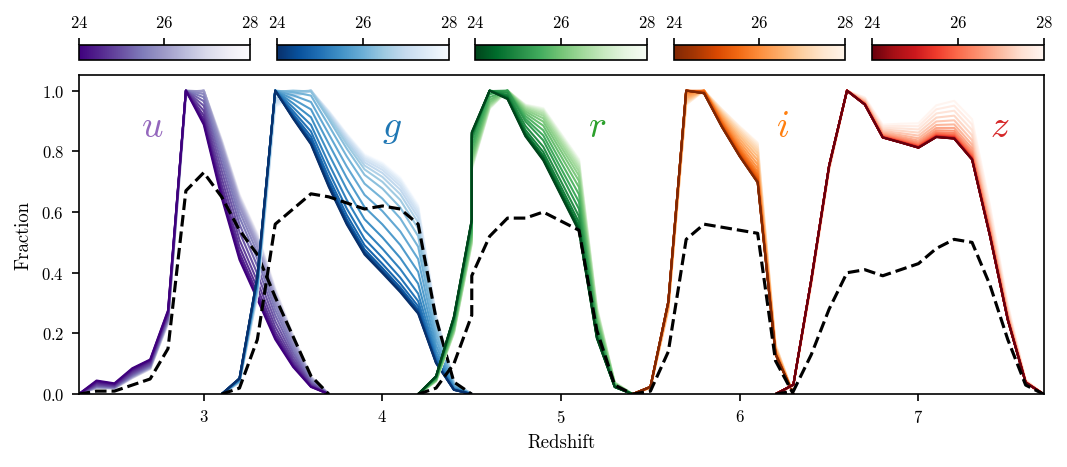

In [2]:
fig, ax = plt.subplots(figsize=double_col, constrained_layout=True, dpi=150)

# Set axis properties
ax.set(
    xlim=(2.3, 7.7),
    ylim=(0, 1.05),
    xlabel="Redshift",
    ylabel="Fraction"
)

# Determine colorbar positions
N = 5
xmin, xmax = ax.get_xlim()
sep = 0.15
wid = ((xmax - xmin) - (N-1) * sep) / N
xstart = [i * (wid + sep) + xmin for i in range(N)]
cbar_pos = [
    [xs, 1.1, wid, 0.05]
    for xs in xstart
]

for i, band in enumerate("ugriz"):
    # Get redshift distributions for range of limiting magnitudes
    m5 = np.linspace(24, 28, 20)
    z, pz = redshift_distribution(m5, band)

    # create LineCollection
    segments = [np.column_stack([z, p / p.max()]) for p in pz]
    lc = LineCollection(segments[::-1], array=m5[::-1], cmap=cmaps[band]+"_r", lw=1)
    ax.add_collection(lc)

    ax.plot(*get_completeness(band), c="k", ls="--")

    cax = ax.inset_axes(cbar_pos[i], transform=ax.transData)
    cb = fig.colorbar(lc, shrink=0.2, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.set_xlim(24, 28)

# Plot band labels
plt.text(2.65, 0.85, "$u$", fontsize=18, color=colors["u"])
plt.text(4, 0.85, "$g$", fontsize=18, color=colors["g"])
plt.text(5.15, 0.85, "$r$", fontsize=18, color=colors["r"])
plt.text(6.2, 0.85, "$i$", fontsize=18, color=colors["i"])
plt.text(7.4, 0.85, "$z$", fontsize=18, color=colors["z"])



fig.savefig("figures/pz_and_completeness.pdf")

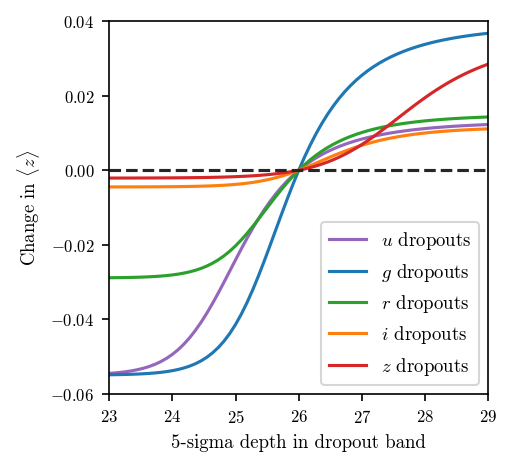

In [3]:
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

for band in "ugriz":
    m5 = cache_pz_stat["m5"]
    mean = cache_pz_stat["pz_mean"][band]
    sig = cache_pz_stat["pz_sig"][band]
    
    norm_mean = np.interp(26, m5, mean)
    ax.plot(m5, mean - norm_mean, c=colors[band], label=f"${band}$ dropouts")

ax.legend()
ax.set(
    xlim=(23, 29),
    ylim=(-0.06, 0.04),
    xlabel="5-sigma depth in dropout band",
    ylabel=r"Change in $\langle z \rangle$",
)
ax.axhline(0, ls="--", c=colors["black"])

fig.savefig("figures/pz_mean.pdf")

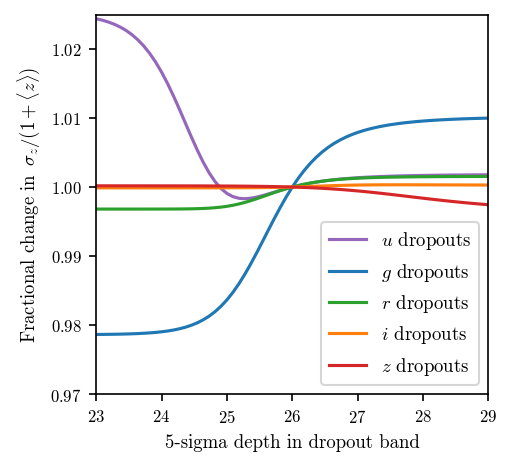

In [4]:
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

for band in "ugriz":
    m5 = cache_pz_stat["m5"]
    mean = cache_pz_stat["pz_mean"][band]
    sig = cache_pz_stat["pz_sig"][band]
    
    norm_sig = np.interp(26, m5, sig)
    ax.plot(m5, sig / norm_sig, c=colors[band], label=f"${band}$ dropouts")

ax.legend()
ax.set(
    xlim=(23, 29),
    ylim=(0.97, 1.025),
    #xticks=np.arange(24, 29, 1),
    #yticks=np.arange(0.85, 1.025, 0.05),
    xlabel="5-sigma depth in dropout band",
    ylabel=r"Fractional change in $\, \sigma_z / (1 + \langle z \rangle)$",
)

fig.savefig("figures/pz_sig.pdf")